In [37]:
%reload_ext autoreload
%autoreload 
%matplotlib inline 
# qt4 
import IPython
IPython.core.pylabtools.figsize(3, 2)
from IPython.display import HTML, display, Latex
import os
import numpy as np
import pickle
import math
import itertools
import matplotlib.pylab as plt
import matplotlib
from scipy import stats
import seaborn as sns
import tabulate
from sklearn import linear_model
import flashvideosynchronization
import imagesource

In [38]:
# download the input files
!mkdir -p data/ice_hockey
!wget -q --show-progress -nc -P data/ice_hockey http://ptak.felk.cvut.cz/personal/smidm1/synchronization/ice_hockey/1.mp4
!wget -q --show-progress -nc -P data/ice_hockey http://ptak.felk.cvut.cz/personal/smidm1/synchronization/ice_hockey/2.mp4    
!wget -q --show-progress -nc -P data/ice_hockey http://ptak.felk.cvut.cz/personal/smidm1/synchronization/ice_hockey/3.mp4
!wget -q --show-progress -nc -P data/ice_hockey http://ptak.felk.cvut.cz/personal/smidm1/synchronization/ice_hockey/4.mp4

In [39]:
paper_figures_dir = 'out/figures'
if not os.path.exists(paper_figures_dir):
    os.makedirs(paper_figures_dir)
out_events_dir = 'out/events' 
if not os.path.exists(out_events_dir):
    os.makedirs(out_events_dir)    
cameras = [1, 2, 3, 4]
filenames = {cam: 'data/ice_hockey/%d.mp4' % cam for cam in cameras}

In [40]:
# matplotlib settings

publish = False  # save figures for publication

if publish:
    fig_width_in = 4 # 2.953 # real column width -> too thick lines, font size probably also too big
    fig_height_in = fig_width_in * 0.7
       
    sns.set_style('ticks')
    sns.set_context("paper")
    sns.set_palette(sns.color_palette('muted')) 
    sns.set_color_codes()
    
    params = {
        'figure.figsize': [fig_width_in, fig_height_in],
        'figure.dpi' : 80,
        'text.usetex': False,
        'font.family': 'serif',
        'savefig.dpi' : 300,
       }   
else:
    fig_width_in = 2 
    fig_height_in = fig_width_in * 0.7    
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    params = {}
#     params = {
#         'figure.figsize': [fig_width_in, fig_height_in],
#         'figure.dpi' : 80,
#         'text.usetex': False,
#     #    'font.family': 'serif',
#         'savefig.dpi' : 300,
#        }
    
plt.rcParams.update(params)    

In [41]:
sources = {cam: imagesource.TimedVideoSource(filenames[cam])
          for cam in cameras}
for source in sources.itervalues():
    source.extract_timestamps()

In [42]:
images_dimensions = {}
for cam in cameras:
    img = sources[cam].get_image(0)
    images_dimensions[cam] = img.shape
obsolete_regions = {cam: {'top': 28, 'bottom': images_dimensions[cam][0] - 1}
                    for cam in cameras}
override_good = {0: [], 1: [1917, 5983, 10718], 2: [3605, 5122, 14935], 3: [6415, ], 4: []}  # force to stay
override_start = {0: [], 1: [(10718, 983), ], 2: [], 3: [(6415, 633), ], 4: []}  # force to stay and fix start
override_bad = {0: [], 1: [], 2: [12992, ], 3: [], 4: []}  # force to filter out

In [43]:
sync = flashvideosynchronization.FlashVideoSynchronization()

## Event Detection

In [62]:
sync.detect_flash_events(filenames)

matching_events = {1: 3, 3: 2, 2: 8, 4: 2}
offsets = {cam: sync.events[cam][matching_events[cam]]['time'] for cam in cameras}
sync.filter_events(obsolete_regions, override_good, override_bad, override_start)

[Memory]4510.6s, 75.2min: Loading detect_events_in_video-alias...
[Memory]4510.6s, 75.2min: Loading detect_events_in_video-alias...
[Memory]4510.6s, 75.2min: Loading detect_events_in_video-alias...
[Memory]4510.6s, 75.2min: Loading detect_events_in_video-alias...


In [63]:
t = [[cam, len(sync.events[cam])] for cam in cameras]
HTML(tabulate.tabulate(t, ['camera', 'flashes'], tablefmt='html'))

## Single Stream Analysis

In [105]:
cam = 2

In [106]:
# load features
features = {cam: flashvideosynchronization.extract_features(filenames[cam], dtype=np.uint8) for cam in cameras}

[Memory]5239.9s, 87.3min: Loading extract_features-alias...
[Memory]5240.1s, 87.3min: Loading extract_features-alias...
[Memory]5240.1s, 87.3min: Loading extract_features-alias...
[Memory]5240.2s, 87.3min: Loading extract_features-alias...


In [107]:
# compute 2d diff, 1d max features and artefact locations
f2d = np.diff(features[cam].astype(float), axis=1)
f1d = np.max(f2d, axis=0)
diff_thresh = 20
events_idx = np.nonzero(f1d > diff_thresh)[0] + 1

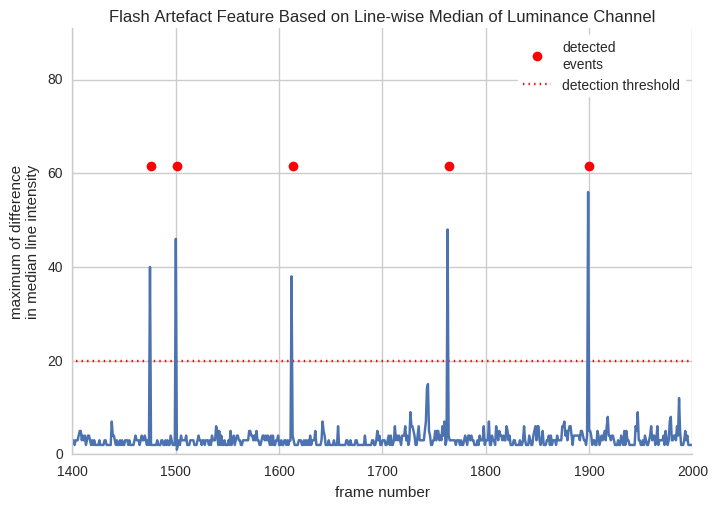

In [108]:
# plot max diff and peak detection (max (ax=0) diff (ax=1) median (ax=1) luminance)
plot_range = (1400, 2000)

fig = plt.figure()
plt.plot(f1d)
plt.plot(events_idx, len(events_idx) * [max(f1d[slice(*plot_range)]) * 1.1], 'ro', label='detected\nevents')
plt.hlines(diff_thresh, 0, len(f1d),
           colors='r', linestyles='dotted', label='detection threshold')
if not publish:
    plt.title('Flash Artefact Feature Based on Line-wise Median of Luminance Channel')
plt.xlabel('frame number')
plt.ylabel('maximum of difference\nin median line intensity')
plt.ylim(ymax=plt.ylim()[1] * 1.3)
plt.xlim(*plot_range)
legend = plt.legend(loc='upper right', frameon=True)
frame = legend.get_frame()
frame.set_color('white')
sns.despine(fig)
if publish:
    plt.tight_layout()
    plt.savefig(os.path.join(paper_figures_dir, 'feature1d_with_detections_cam%d.pdf' % cam))

## Single Event Analysis

In [67]:
# select event
cam = 1
frame = 1765
# or select an event
# event_n = 3
# frame = sync.events[cam][event_n]['frame']

diff2d = np.diff(features[cam].astype(float), axis=1)
img = sources[cam].get_image(frame)

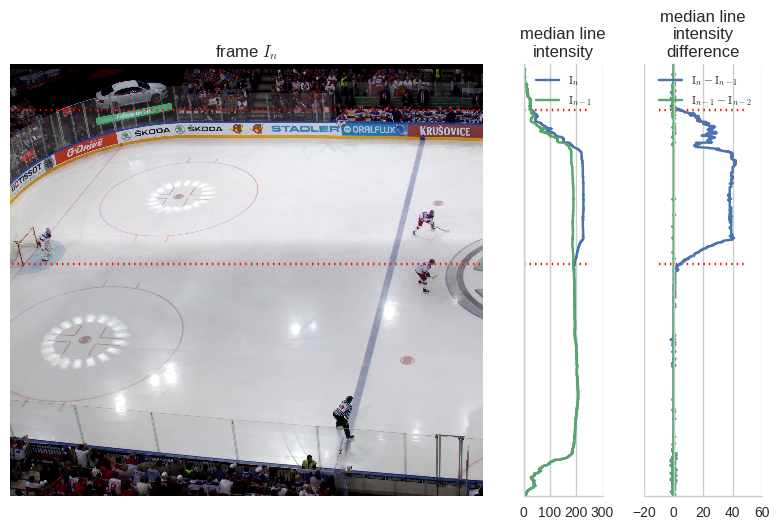

In [68]:
# plot flash image with corresponding profiles
__, start, end = flashvideosynchronization.ramp_detection(diff2d[:, frame - 1])

if publish:
    fig = plt.figure()
    fig.set_size_inches(fig_width_in * 2, fig_height_in * 2 * 0.8, forward=True)

sync.plot_frame_with_profile(img, frame, features[cam], start, end)

if publish:
    filename='flash_with_profiles_c%d_f%d.pdf' % (cam, frame)
    plt.savefig(os.path.join(paper_figures_dir, filename))

In [69]:
# batch save all events (generates lots of images, enable as you like)
# sync.save_event_images(sources, features, out_events_dir)

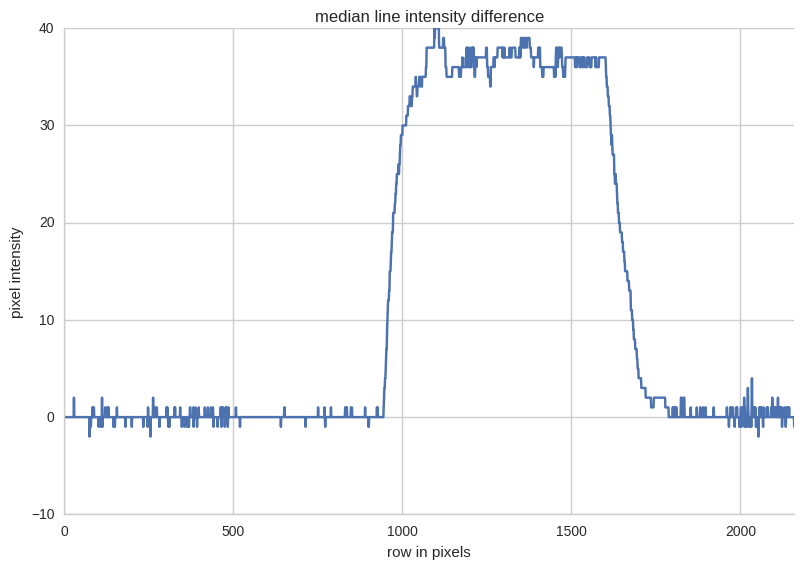

In [70]:
# plot diff profile
cam = 2
event_n = 0
frame = sync.events[cam][event_n]['frame']

f2d = np.diff(features[cam].astype(float), axis=1)
profile = f2d[:, frame - 1]

fig = plt.figure()
if not publish:    
    plt.title('median line intensity difference')
else:
    fig.set_size_inches(fig_width_in, fig_height_in * 0.5)
plt.plot(range(len(profile)), f2d[:, frame - 1])
plt.locator_params(axis='y', nbins=5)
plt.ylabel('pixel intensity')
plt.xlabel('row in pixels')
sns.despine(fig)
plt.tight_layout(0)
plt.autoscale(axis='x', tight=True)

if publish:
    filename = 'diff_profile_c%d_f%d.pdf' % (cam, frame)
    plt.savefig(os.path.join(paper_figures_dir, filename))

## Synchronization

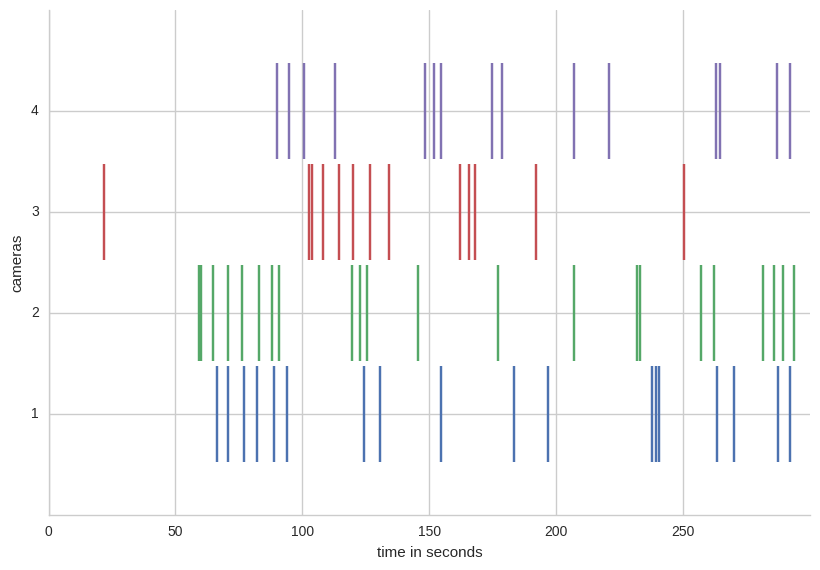

In [71]:
# visualize not synchronized events
sync.show_events()
if publish:
    plt.savefig(os.path.join(paper_figures_dir, 'events_not_synchronized_' + '_'.join([str(c) for c in cameras]) + '.pdf'))            

In [72]:
# manual event association (using the plot above)
matching_events = {1: 0, 2: 1, 3: 2, 4: 3}

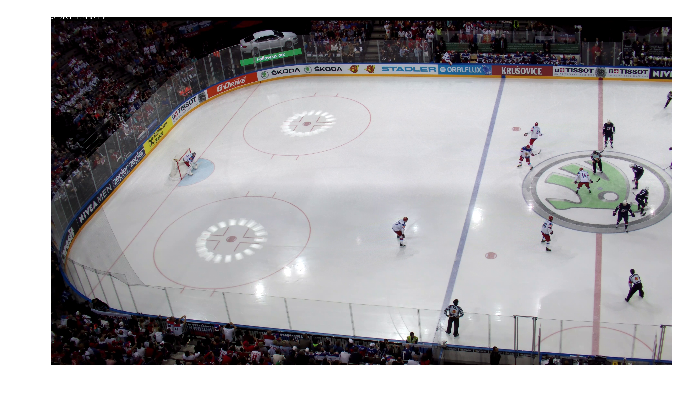

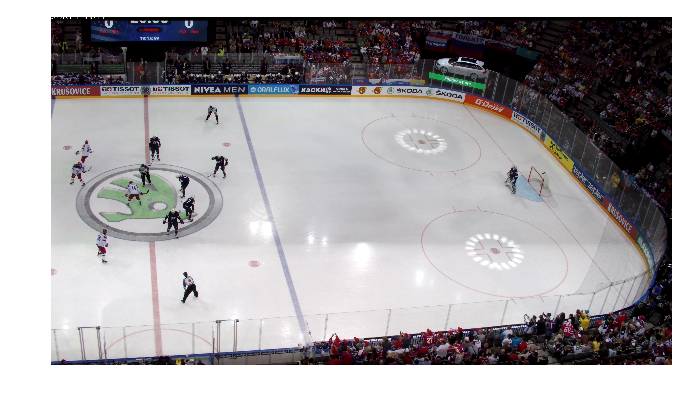

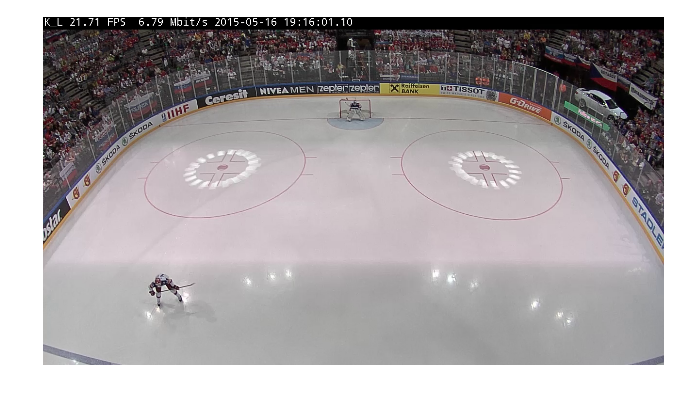

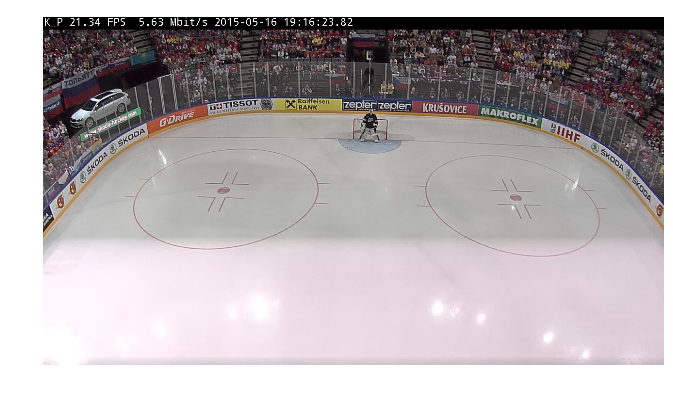

In [73]:
# show paired event frames side by side
if publish:    
    ydim = int(math.floor(math.sqrt(len(cameras))))
    xdim = int(math.ceil(len(cameras) / ydim))
    frame_str = ''
    fig = plt.figure()

for i, (cam, idx) in enumerate(matching_events.iteritems()):
    frame = sync.events[cam][idx]['frame']
    if publish:
        plt.subplot(ydim, xdim, i + 1)
        frame_str += '_' + str(frame)
    else:
        plt.figure()
    plt.imshow(sources[cam].get_image(frame)) 
    plt.grid(False)
    plt.axis('off')

if publish:
    fig.set_size_inches(fig_width_in, fig_height_in)
    plt.tight_layout(0) # pad=1)
    plt.savefig(os.path.join(paper_figures_dir, 'flashes%s.png' % frame_str))

### Events Matching

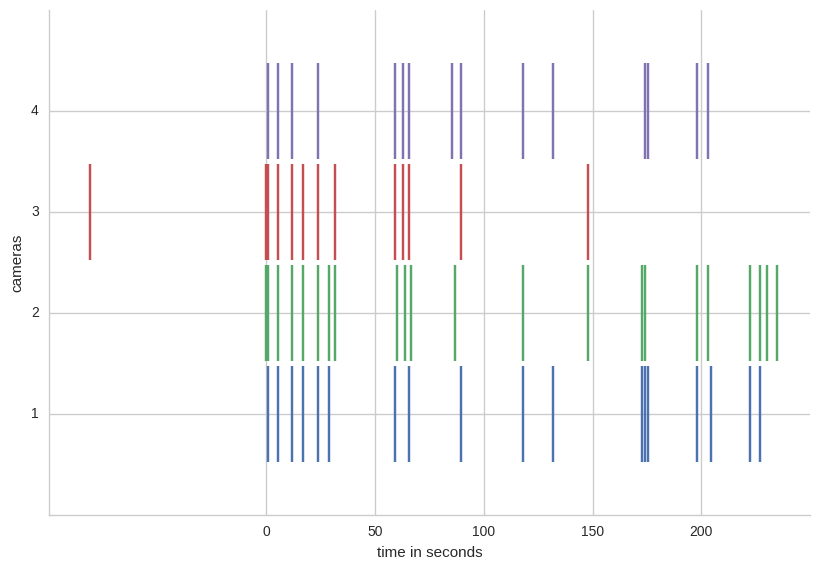

In [74]:
sync.show_events(offsets)
if publish:
    plt.savefig(os.path.join(paper_figures_dir, 'events_' + '_'.join([str(c) for c in cameras]) + '.pdf'))            

In [75]:
matched_events = sync.get_matched_events(cameras, offsets)

### Model Fitting

In [76]:
images_dimensions

{1: (2160, 3840, 3), 2: (2160, 3840, 3), 3: (720, 1280, 3), 4: (720, 1280, 3)}

In [77]:
# numbers of matched events
{(cam1, cam2): len(sync.get_matched_events([cam1, cam2], offsets)[cam1])
 for cam1, cam2 in itertools.combinations(cameras, 2)}

{(1, 2): 12, (1, 3): 8, (1, 4): 12, (2, 3): 8, (2, 4): 8, (3, 4): 8}

In [78]:
# results table formatting
def format_table(table, formats):
    table_out = []
    for row in table:
        out_row =[]
        for item, fmt in zip(row, formats):
            if fmt is None:
                out_row.append(item)
            elif isinstance(fmt, str):
                out_row.append(fmt % item)
            else:
                out_row.append(fmt(item))
        table_out.append(out_row)
    return table_out

r2 = lambda x: round(x, 2)
r4 = lambda x: round(x, 4)

In [79]:
# example matched events for pair of cameras
camera_pair = [1, 2]
matched_events_ = sync.get_matched_events(camera_pair, offsets)
e = matched_events_[camera_pair[0]]
print(tabulate.tabulate(e, headers=e.dtype.names))
print('\n')
e = matched_events_[camera_pair[1]]
print(tabulate.tabulate(e, headers=e.dtype.names))

  frame    start    end    time
-------  -------  -----  ------
   1653      409   1134   66217
   1765      233   1000   70779
   1917      936   1969   76860
   2051      729   1477   82302
   2215      890   1637   88943
   2336     1708   2159   93865
   4557     1834   2159  183209
   5918     1656   2159  237783
   5950      893   1638  239144
   6548      564   1332  263230
   7148      217    974  287397
   7259      805   1547  291958


  frame    start    end    time
-------  -------  -----  ------
   1501     1408   2144   60136
   1613     1246   2043   64697
   1764     1968   2159   70779
   1900     1757   2159   76221
   2064     1922   2159   82862
   2187      103    849   87824
   4383      230    992  177168
   5744       46    780  231744
   5777     1908   2159  233064
   6379     1574   2159  257151
   6977     1212   2014  281317
   7089     1816   2159  285879


#### Fit clock drift and temporal shift for camera pairs with predefined constants

In [80]:
parameters = {1: {'sensor_rows': 2625, 'mode_duration_ms': 40},
              2: {'sensor_rows': 2625, 'mode_duration_ms': 40},
              3: {'sensor_rows': 978,  'mode_duration_ms': 40},
              4: {'sensor_rows': 978,  'mode_duration_ms': 40},
              }

t = []
for cam1, cam2 in itertools.combinations(cameras, 2):
    events_ij = sync.get_matched_events([cam1, cam2], offsets)

    sync.synchronize_with_parameters(cam1, cam2, offsets, parameters=parameters)
    times1 = sync.get_time(cam1, events_ij[cam1]['time'], events_ij[cam1]['start'])
    times2 = sync.get_time(cam2, events_ij[cam2]['time'], events_ij[cam2]['start'])

    n = len(events_ij[cam1])
    t.append(['%d %d' % (cam1, cam2),
              n,
              1 - sync.model[cam2]['drift'],
              sync.model[cam2]['shift'],
              (times1 - times2).std(),
              ])
headers = ['camera', 'events', '1 - drift', 'shift (in ms)', 'std (in ms)']
HTML(tabulate.tabulate(t, headers=headers, tablefmt='html'))

#### Fit clock drift, temporal shift and time per row for camera pairs

In [81]:
t = []
for cam1, cam2 in itertools.combinations(cameras, 2):
    events_ij = sync.get_matched_events([cam1, cam2], offsets)

    sync.synchronize([cam1, cam2], offsets)
    times1 = sync.get_time(cam1, events_ij[cam1]['time'], events_ij[cam1]['start'])
    times2 = sync.get_time(cam2, events_ij[cam2]['time'], events_ij[cam2]['start'])

    n = len(events_ij[cam1])
    t.append(['%d %d' % (cam1, cam2),
              n,
              1 - sync.model[cam2]['drift'],
              (sync.model[cam2]['drift'] - 1) * (1 / sync.model[cam2]['time_per_row']) * 1000,
              sync.model[cam2]['shift'],
              sync.model[cam1]['time_per_row'],
              sync.model[cam2]['time_per_row'],
              (times1 - times2).std(),
              ])
headers = ['camera', 'events', '1 - drift', 'drift (in lines/s)',
           'shift (in ms)',            
           't/row cam1', 't/row cam2', 
           'std (in ms)']
HTML(tabulate.tabulate(t, headers=headers, tablefmt='html'))

In [84]:
# format the results table for publication
formats = [None, None, lambda x: str(round((x) * 10 ** 6, 2)) + ' e6', 
           r2, r2, r4, r4, r2]
HTML(tabulate.tabulate(format_table(t, formats), headers, tablefmt='html'))

In [85]:
# output the latex version of the results table
tabulate.LATEX_ESCAPE_RULES = {}

formats = [None, None, lambda x: str(round((x) * 10 ** 6, 2)) + r' $\times10^{-6}$', 
           r2, r2, r4, r4, r2]
table_formatted = format_table(t, formats)

# remove 2nd column
table_formatted_ = []
for row in table_formatted:
    del row[1]
    table_formatted_.append(row)
    
Latex(tabulate.tabulate(table_formatted_, tablefmt='latex_booktabs')) # tabular not yet supported by the MathJax backend

<IPython.core.display.Latex object>

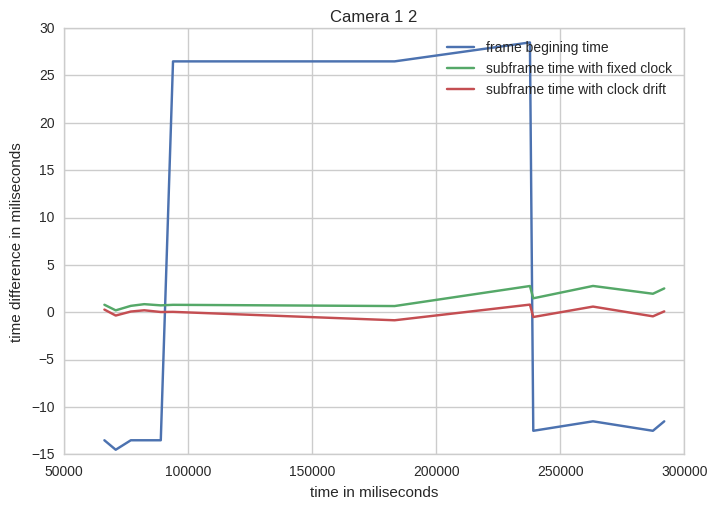

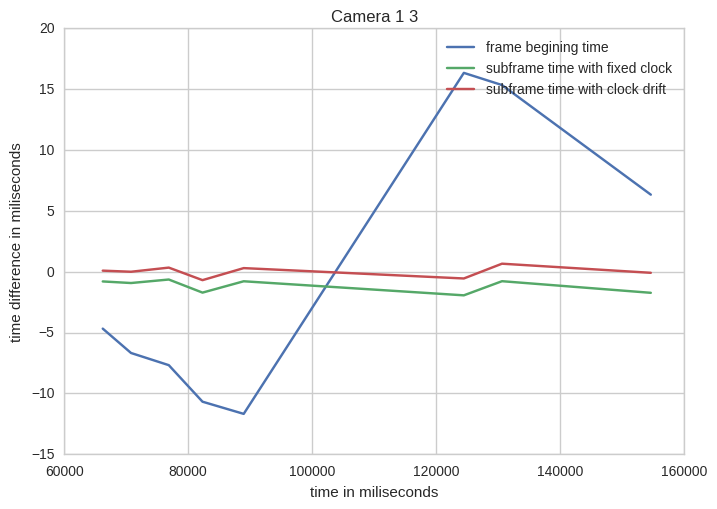

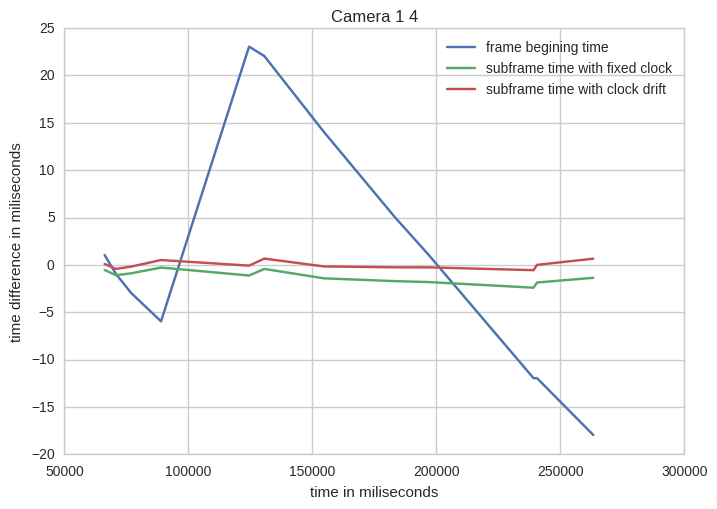

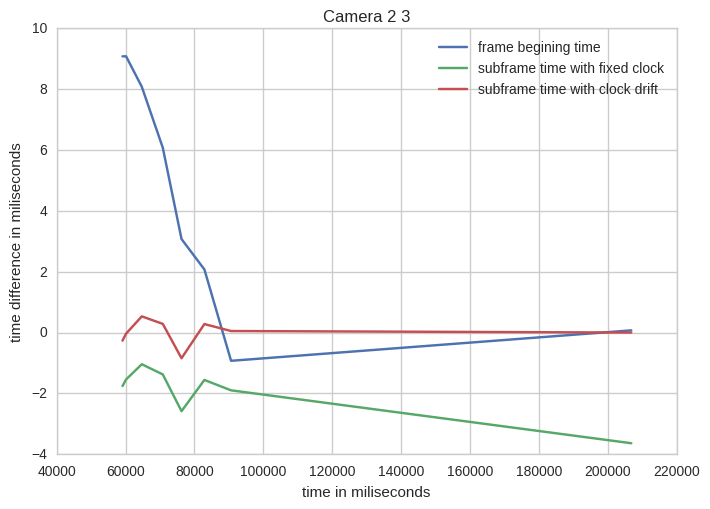

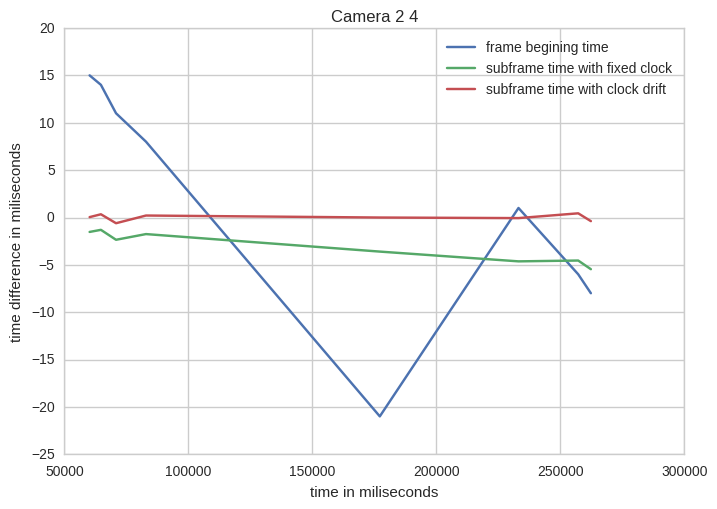

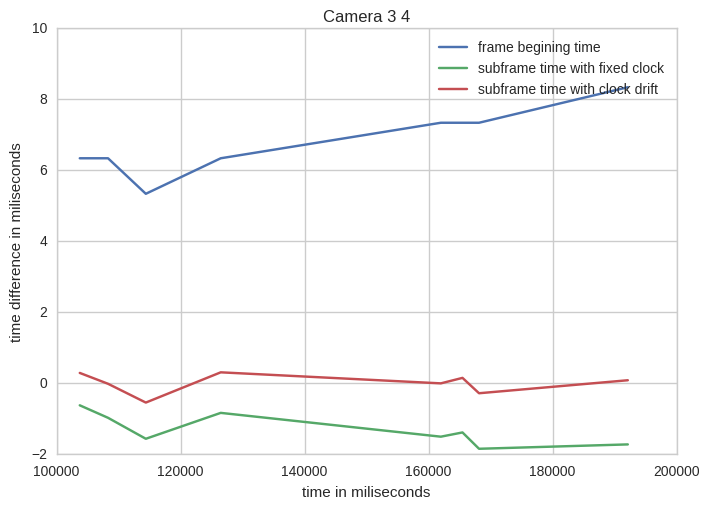

In [86]:
for cam1, cam2 in itertools.combinations(cameras, 2):
    events_ij = sync.get_matched_events([cam1, cam2], offsets)
    sync.synchronize([cam1, cam2], offsets)
    times1 = sync.get_time(cam1, events_ij[cam1]['time'], events_ij[cam1]['start'])
    times2 = sync.get_time(cam2, events_ij[cam2]['time'], events_ij[cam2]['start'])

    fig = plt.figure()
    plt.title('Camera %d %d' % (cam1, cam2))
    plt.plot(times1, 
             events_ij[cam2]['time'] + sync.model[cam2]['shift']
             - events_ij[cam1]['time'], 
             label='frame begining time')
    plt.plot(times1, (events_ij[cam2]['time'] + sync.model[cam2]['shift']
                       + sync.model[cam2]['time_per_row'] * events_ij[cam2]['start']) 
                       - times1,
             label='subframe time with fixed clock')
    plt.plot(times1, times2 - times1, 
             label='subframe time with clock drift')
    plt.grid(True)
    plt.ylabel('time difference in miliseconds')
    plt.xlabel('time in miliseconds')
    plt.legend()

#### Fit clock drift, temporal shift and time per row for all cameras

In [87]:
reference_cam = 1
sync.synchronize(cameras, offsets, reference_cam)
t = []
for cam in set(cameras) - {reference_cam}:
    events_ij = sync.get_matched_events([reference_cam, cam], offsets)
    times1 = sync.get_time(reference_cam, events_ij[reference_cam]['time'], events_ij[reference_cam]['start'])
    times2 = sync.get_time(cam, events_ij[cam]['time'], events_ij[cam]['start'])
    n = len(events_ij[cam])
    t.append(['%d %d' % (reference_cam, cam),
              n,
              1 - sync.model[cam]['drift'],
              (sync.model[cam]['drift'] - 1) * (1 / sync.model[cam]['time_per_row']) * 1000,
              sync.model[cam]['shift'],
              sync.model[cam]['time_per_row'],
              (times1 - times2).std(),
              ])
headers = ['camera', 'events', '1 - drift', 'drift (in lines/s)',
           'shift (in ms)', 't/row cam2', 'std (in ms)']

print('Reference camera time per row: %f' % r4(sync.model[reference_cam]['time_per_row']))

HTML(tabulate.tabulate(t, headers=headers, tablefmt='html'))

Reference camera time per row: 0.015400


In [88]:
# format numbers in the results table
formats = [None, None, lambda x: str(round((x) * 10 ** 6, 2)) + ' e6', 
           r2, r2, r4, r2]
HTML(tabulate.tabulate(format_table(t, formats), headers=headers, tablefmt='html'))

In [89]:
# output the latex version of the results table
tabulate.LATEX_ESCAPE_RULES = {}

formats = [None, None, lambda x: str(round((x) * 10 ** 6, 2)) + r' $\times10^{-6}$', 
           r2, r2, r4, r2]
table_formatted = format_table(t, formats)

# remove 2nd column
table_formatted_ = []
for row in table_formatted:
    del row[1]
    table_formatted_.append(row)
    
Latex(tabulate.tabulate(table_formatted_, tablefmt='latex_booktabs')) # tabular not yet supported by the MathJax backend

<IPython.core.display.Latex object>

#### Frame Synchronization

In [90]:
reference_cam = 1
sync.synchronize(cameras, offsets, reference_cam)
timestamps = {cam: sources[cam].timestamps_ms for cam in cameras}

In [91]:
sync_timing, sync_frames, _ = sync.get_synchronized_frames(timestamps, master=1, perfect_master=False, dropped=True)

In [92]:
# np.savetxt('sync_frames.csv', sync_frames, delimiter=',')  # inspect the synchronized timing in a spreadsheet

In [93]:
sync_timing

array([[      0.  ,      -1.  ,      -1.  ,      -1.  ],
       [     40.  ,      -1.  ,      56.9 ,      20.53],
       [     80.  ,      -1.  ,      96.9 ,      60.54],
       ..., 
       [ 262390.  ,  262375.55,  262402.72,  262374.72],
       [ 262430.  ,  262415.55,  262442.72,  262414.73],
       [ 262470.  ,  262455.55,  262482.72,  262454.73]])

In [94]:
sync_frames

array([[   0,   -1,   -1,   -1],
       [   1,   -1,  790,  505],
       [   2,   -1,  791,  506],
       ..., 
       [6527, 6358, 6292, 6052],
       [6528, 6359, 6293, 6053],
       [6529, 6360, 6294, 6054]])

In [95]:
# convert -1 to nan for statistic evaluation
sync_timing_nan = sync_timing.copy()
sync_timing_nan[sync_timing_nan == -1] = np.nan

sync_timing_errors = sync_timing_nan - sync_timing_nan[:, 0].reshape(-1, 1)
print('Mean absolute synchronization error: ' + str(np.nanmean(np.abs(sync_timing_errors), axis=0)))

Mean absolute synchronization error: [  0.    14.95  10.32   9.68]


In [96]:
print('Number of frames where no camera has a dropped frame: %d out of total %d frames.' % 
      (np.count_nonzero(np.all(sync_frames != -1, axis=1)), len(sync_frames)))

Number of frames where no camera has a dropped frame: 4484 out of total 6530 frames.


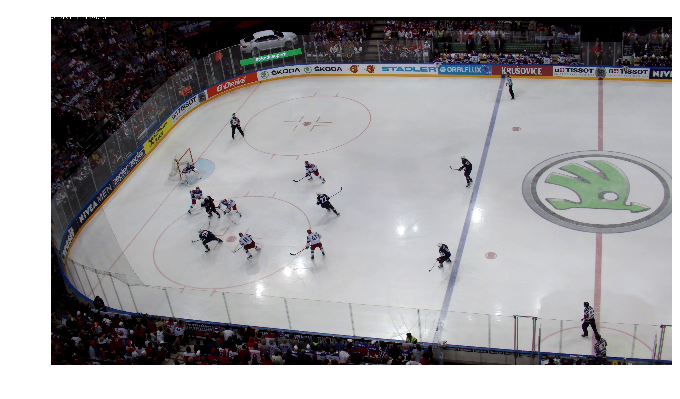

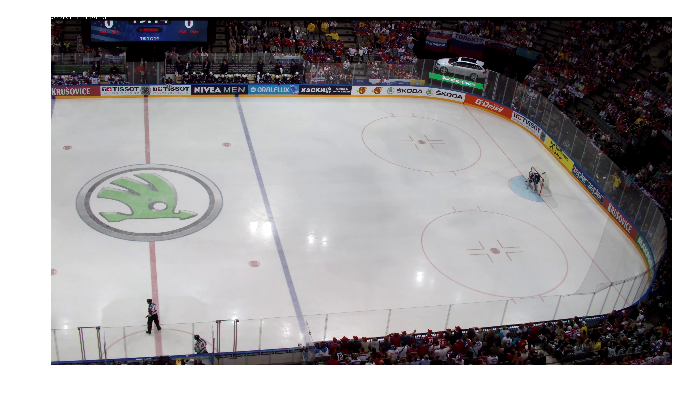

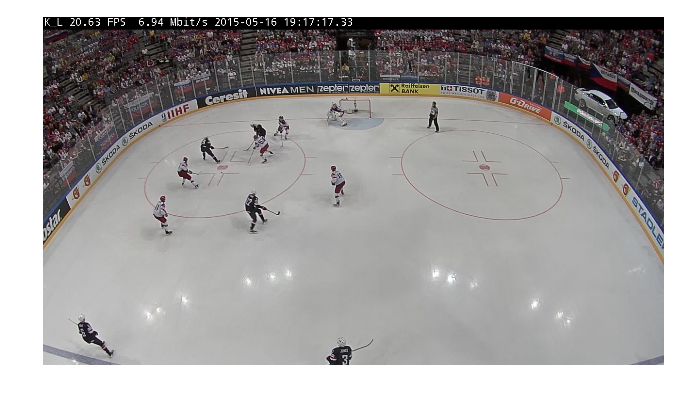

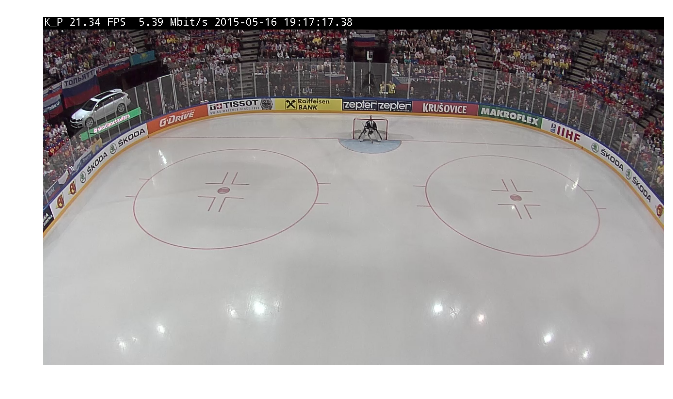

In [97]:
# frame = 4000

sources_sync = sync.get_synchronized_image_sources(sources, dropped=False) # , perfect_master=False)

if publish:
    ydim = int(math.floor(math.sqrt(len(cameras))))
    xdim = int(math.ceil(len(cameras) / ydim))
    frame_str = ''
    fig = plt.figure()

for i, (cam, source) in enumerate(sources_sync.iteritems()):
    if publish:
        plt.subplot(ydim, xdim, i + 1)
        plt.title('err: %02.f ms' % source.get_synchronization_error(frame))
    else:
        plt.figure()
    img = source.get_image(frame)
    if img is not None:
        plt.imshow(img)
    plt.grid(False)
    plt.axis('off')

### Puck Shot Sub-frame Interpolation

In [98]:
# setup triplet of images

# selected_cams = [3, 1, 1]
# selected_frames = [11258, -1, -1]
# coords = np.array([[355, 325],
#                   [-1, -1],
#                   [-1, -1]], dtype=float)

# # 1
# selected_cams = [3, 1, 1]
# selected_frames = [3919, -1, -1]
# alpha, beta = table[1, 1:3]

# # 2
# selected_cams = [3, 1, 1]
# selected_frames = [6622, -1, -1]
# alpha, beta = table[1, 1:3]

# 3
selected_cams = [3, 1, 1]
selected_frames = [3903, -1, -1]

In [99]:
# synchronize with respect to selected_cams[0]
timestamps = {cam: sources[cam].timestamps_ms for cam in cameras}
sync_timing, sync_frames, _ = sync.get_synchronized_frames(timestamps, 
                                                           master=selected_cams[0], 
                                                           perfect_master=False, dropped=True)
sources_sync = sync.get_synchronized_image_sources(sources, master=selected_cams[0],
                                                   perfect_master=False, dropped=True)

In [100]:
# find synchronized images 
idx = np.nonzero(sync_frames[:, cameras.index(selected_cams[0])] == selected_frames[0])[0][0]


selected_frames[1] = sync_frames[idx, cameras.index(selected_cams[1])]
selected_frames[2] = sync_frames[idx, cameras.index(selected_cams[2])] + 1
selected_frames

[3903, 3693, 3694]

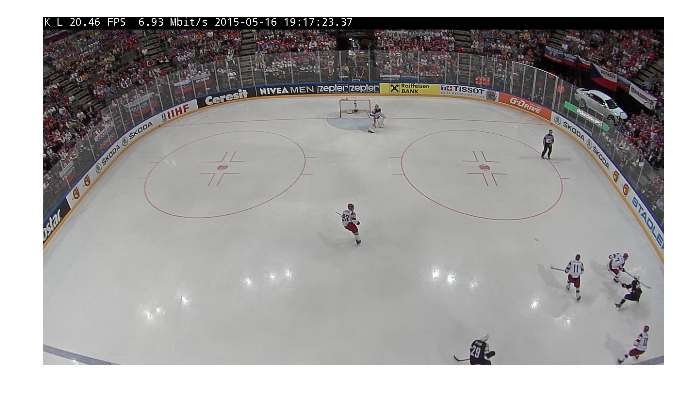

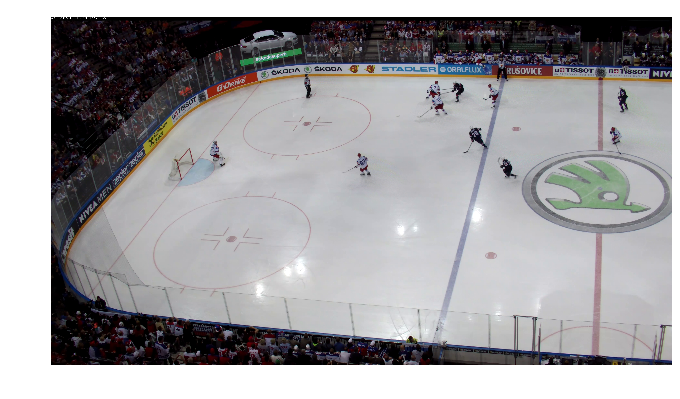

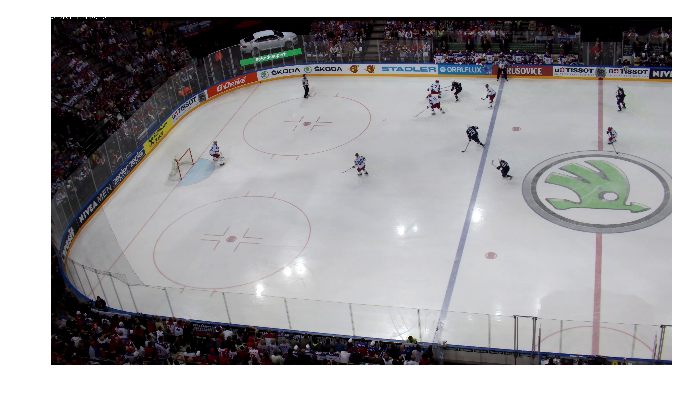

In [101]:
# show images with the puck (in %matplotlib qt4 or gtk modes suitable for writing down the puck coordinates)
for cam, frame in zip(selected_cams, selected_frames):
    plt.figure()
    plt.imshow(sources[cam].get_image(frame))
    plt.axis('off')

In [102]:
# # puck centroid coodinates in three images
#
# 1
# coords = np.array([[573, 219],
#                   [-1, -1],
#                   [-1, -1]], dtype=float)

# # 2
# coords = np.array([[245, 362],
#                    [1246, 1577],
#                   [1254, 1530]], dtype=float)

# 3
coords = np.array([[1017, 460],
                  [2147, 619],
                  [2062, 644]], dtype=float)

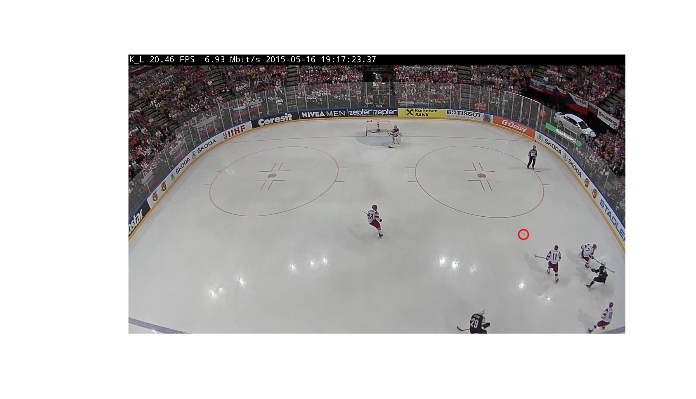

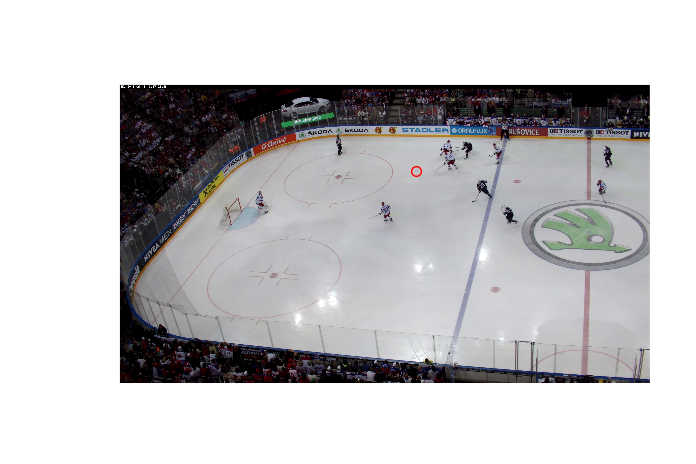

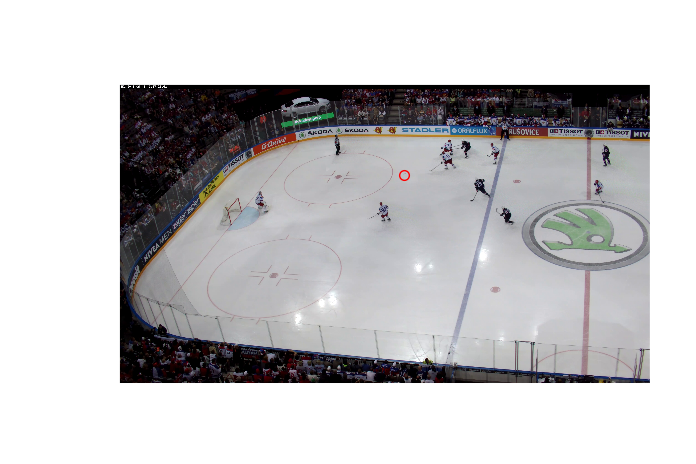

In [103]:
for cam, frame, coord in zip(selected_cams, selected_frames, coords):
    fig = plt.figure()
    plt.imshow(sources[cam].get_image(frame))
    plt.plot(coord[0], coord[1], 'o', 
             markersize=7, markeredgewidth=1, markeredgecolor='r', markerfacecolor='None')
    plt.axis('off')
    
    # fig.set_size_inches(24, 12)
    # plt.tight_layout(pad=0)
    # plt.savefig('out/puck_subframe_c%d_%d.png' % (cam, frame))    

In [104]:
# compute the sub-frame puck time for all three images
puck_time = []
for cam, frame, coord in zip(selected_cams, selected_frames, coords):
    puck_time.append(sync.get_time(cam, timestamps[cam][frame], coord[1]))
puck_time    

[148507.49105717428, 148488.56279951328, 148528.94901920285]

In [ ]:
assert False

In [ ]:
#TODO: transform the images to a common frame
#
# for the purpose of paper was done semi-manually with dependency on not released code

In [ ]:
# plane_images = ...

In [ ]:
img_merge = np.zeros_like(plane_images[0])
img_merge[:, :, 0] = cv2.cvtColor(plane_images[0].astype(np.uint8), cv2.COLOR_RGB2GRAY)
img_merge[:, :, 1] = cv2.cvtColor(plane_images[1].astype(np.uint8), cv2.COLOR_RGB2GRAY)
img_merge[:, :, 2] = cv2.cvtColor(plane_images[2].astype(np.uint8), cv2.COLOR_RGB2GRAY)

In [ ]:
plt.imshow(img_merge)

In [ ]:
plt.imsave('out/puck_merge_c%d_%d.png' % (selected_cams[0], selected_frames[0]), img_merge)
# fix homography in out/puck_merge_xx.png, save it as out/puck_merge_xx_fixed.png
# gimp: crop; colors - components - decompose; projective transform of r layer (tool setting: layer opacity);
#       layer - layer to image size; colors - components - compose

In [ ]:
img_merge_fixed = plt.imread('out/puck_merge_c%d_%d_fixed.png' % (selected_cams[0], selected_frames[0]))
plt.imshow(img_merge_fixed)
# save coordinates

In [ ]:
# # 2
# coords_rectified = np.array([
#         [171.6, 63.6],
#         [170.6, 62.3],
#         [158, 66.3]
#     ])

# 3
coords_rectified = np.array([
        [113, 31],
        [107, 25],
        [119, 42]
    ])

In [ ]:
plt.imshow(img_merge_fixed)
plt.scatter(coords_rectified[:, 0], coords_rectified[:, 1], c=['r', 'g', 'b'])

In [ ]:
# draw the interpolated position

coords01 = coords_rectified[1:]
# length = np.linalg.norm(coords01[0] - coords01[1])
ratio = (puck_timings[0] - puck_timings[1]) / (puck_timings[2] - puck_timings[1])
coord_rectified_interp = coords01[1] + (coords01[0] - coords01[1]) * ratio

fig = plt.figure()
plt.imshow(img_merge_fixed)
for xy, c, l in zip(coords_rectified, ['r', 'g', 'b'], 
                    ['camera %d, time %d' % (cam, timing) for cam, timing in zip(selected_cams, puck_timings)]):
    # plt.plot(xy[0], xy[1], '+', color=c, label=l)
    print c
    print l
    # plt.annotate(l, (xy[0], xy[1]), (10, 0), textcoords='offset points', color=c)  
    
plt.plot(coord_rectified_interp[0], coord_rectified_interp[1],
         'wo', label='iterpolated cam %d'  % selected_cams[1])
l = 'camera %d interpolated\nposition for time %d'  % (selected_cams[1], puck_timings[0])
# plt.annotate(,
#              (coord_rectified_interp[0], coord_rectified_interp[1]), (-130, 0), textcoords='offset points', color='w')
print l
plt.axis('off')
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_color('white')
fig.set_size_inches(24, 12)
plt.tight_layout(pad=0)
plt.savefig('out/puck_subframe_c%d_%d.png' % (selected_cams[0], selected_frames[0]))
plt.close('all')